In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import re
from scipy.stats import spearmanr
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
!wget --header="Host: doc-0k-28-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7,te;q=0.6" --header="Referer: https://drive.google.com/drive/folders/1jDaTjkObjOJtKw_a6UAUdBQjNXBUqPyw" --header="Cookie: AUTH_a6vj9lr9jila39df06jrrjjv0vh3ee7e_nonce=a0gv5ane7299a; NID=201=YcXxrEhUnPpkljFOHDVEtczamxYBktwPo4UgqgEWERwlNvkGBPLf5ROYVTlFD8TCe63d9H5XAdCSV1iHqaQ387y30J3lOCT9bRnFeEjKiO7crtFh15hUO5haIceTzUZ58zCfjou0X0-A-C3B_ABk_ojKkcujnHSp5R0eNWr2xDo" --header="Connection: keep-alive" "https://doc-0k-28-docs.googleusercontent.com/docs/securesc/5ekh8l65ha4ipmup3k8f1odtjhhgm4al/4km23g7beok8alsjhm98gc5uuspqt1k0/1591599450000/00067484657673616182/00067484657673616182/1dOH4PadCvqUwPOJx1U4QVowOW2mZWLN7?e=download&authuser=0&nonce=a0gv5ane7299a&user=00067484657673616182&hash=0pa7v7nbu7cuefs10e4l1fa9hl5bep8t" -c -O 'glove_vectors'

--2020-06-08 06:58:39--  https://doc-0k-28-docs.googleusercontent.com/docs/securesc/5ekh8l65ha4ipmup3k8f1odtjhhgm4al/4km23g7beok8alsjhm98gc5uuspqt1k0/1591599450000/00067484657673616182/00067484657673616182/1dOH4PadCvqUwPOJx1U4QVowOW2mZWLN7?e=download&authuser=0&nonce=a0gv5ane7299a&user=00067484657673616182&hash=0pa7v7nbu7cuefs10e4l1fa9hl5bep8t
Resolving doc-0k-28-docs.googleusercontent.com (doc-0k-28-docs.googleusercontent.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to doc-0k-28-docs.googleusercontent.com (doc-0k-28-docs.googleusercontent.com)|173.194.216.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘glove_vectors’

glove_vectors           [      <=>           ] 121.60M  64.9MB/s    in 1.9s    

2020-06-08 06:58:41 (64.9 MB/s) - ‘glove_vectors’ saved [127506004]



In [4]:
train = pd.read_pickle('./train')
train.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,what am i losing when using extension tubes in...,after playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,i just got extension tubes so here is the skin...,rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,what is the distinction between a city and a s...,i am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,it might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,maximum protusion length for through hole comp...,i am working on a pcb that has through hole co...,Joe Baker,https://electronics.stackexchange.com/users/10157,do you even need grooves we make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,can an affidavit be used in beit din,an affidavit from what i understand is basical...,Scimonster,https://judaism.stackexchange.com/users/5151,sending an affidavit it is a dispute between...,Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,how do you make a binary image in photoshop,i am trying to make a binary image i want more...,leigero,https://graphicdesign.stackexchange.com/users/...,check out image trace in adobe illustrator i...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [5]:
test = pd.read_pickle('./test')
test.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,will leaving corpses lying around upset my pri...,i see questionsinformation online about how to...,Dylan,https://gaming.stackexchange.com/users/64471,there is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,url link to feature image in the portfolio,i am new to wordpress i have issue with featur...,Anu,https://wordpress.stackexchange.com/users/72927,i think it is possible with custom fields add...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,is accuracy recoil or bullet spread affected b...,to experiment i started a bot game toggled inv...,Konsta,https://gaming.stackexchange.com/users/37545,you do not have armour in the screenshots this...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,suddenly got an io error from my external hdd,i have used my raspberry pi as a torrent serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,your western digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,passenger name flight booking passenger only...,i have bought delhi london return flights for ...,Amit,https://travel.stackexchange.com/users/29089,i called two persons who work for saudia tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com


In [0]:
X = pd.DataFrame()
for i in test.columns:
    X[i] = train[i]

In [7]:
X.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host'],
      dtype='object')

In [8]:
features = ['question_title','question_body','answer']
X[features]

,question_title,question_body,answer
0,what am i losing when using extension tubes in...,after playing around with macro photography on...,i just got extension tubes so here is the skin...
1,what is the distinction between a city and a s...,i am trying to understand what kinds of places...,it might be helpful to look into the definitio...
2,maximum protusion length for through hole comp...,i am working on a pcb that has through hole co...,do you even need grooves we make several pro...
3,can an affidavit be used in beit din,an affidavit from what i understand is basical...,sending an affidavit it is a dispute between...
4,how do you make a binary image in photoshop,i am trying to make a binary image i want more...,check out image trace in adobe illustrator i...
...,...,...,...
6074,using a ski helmet for winter biking,i am curious if anyone uses a skiing helmet fo...,if you are thinking about wearing a ski helmet...
6075,adjustment to road bike brakes for high grade ...,i have a road bike with a front brake that wea...,you can replace the pads as stated elsewhere...
6076,suppress file truncated messages when using tail,i am tailing a log file using tail f messages...,maybe help if can be fixes origin of this erro...
6077,when should a supervisor be a co author,what are people is views on this to be speci...,as a non mathematician i am somewhat mystified...


In [0]:
y = pd.DataFrame()
for i in train.columns:
    if i not in X.columns:
        y[i] = train[i]

In [10]:
y.columns

Index(['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

In [11]:
y

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,1.000000,0.333333,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.000000,0.000000,0.000000,1.000000
1,1.000000,1.000000,0.000000,0.500000,1.000000,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.000000,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.000000,0.000000,0.666667,0.888889
2,0.888889,0.666667,0.000000,1.000000,1.000000,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.000000,0.333333,1.000000,0.888889
3,0.888889,0.666667,0.666667,1.000000,1.000000,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.000000,0.000000,1.000000,1.000000
4,1.000000,0.666667,0.000000,1.000000,1.000000,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.000000,0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,1.000000,0.777778,0.000000,1.000000,1.000000,1.0,0.888889,0.888889,0.333333,0.0,0.000000,0.333333,0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.666667,0.0,0.777778,1.000000,0.555556,1.000000,1.000000,0.866667,0.000000,0.000000,0.000000,0.888889
6075,1.000000,0.777778,0.000000,1.000000,0.666667,0.5,0.777778,0.777778,0.000000,0.0,0.666667,0.000000,0.000000,0.0,0.000000,0.0,0.666667,0.666667,0.000000,0.0,0.777778,0.888889,0.555556,1.000000,1.000000,0.733333,0.666667,0.333333,0.000000,0.888889
6076,0.888889,0.555556,0.000000,0.666667,0.333333,1.0,0.444444,0.333333,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.444444,0.888889,0.555556,0.888889,0.888889,0.800000,1.000000,0.000000,0.333333,0.555556
6077,1.000000,0.444444,0.333333,0.000000,0.000000,0.0,0.777778,0.555556,1.000000,0.0,1.000000,0.333333,0.000000,0.0,0.000000,0.0,0.000000,0.333333,0.666667,0.0,1.000000,0.888889,0.555556,1.000000,1.000000,0.533333,0.000000,0.333333,0.666667,1.000000


In [0]:
X_train, X_cv, y_train, y_cv = train_test_split(X[features], y.values, test_size=0.25)

In [0]:
t = Tokenizer(filters = " ")
t.fit_on_texts(X_train['question_title'].values)
vocab_size_question_title = len(t.word_index) + 1
encoded_train_question_title = t.texts_to_sequences(X_train['question_title'].values)
encoded_cv_question_title = t.texts_to_sequences(X_cv['question_title'].values)
encoded_test_question_title = t.texts_to_sequences(test['question_title'].values)

In [0]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

# for train
embedding_matrix_model_question_title = np.zeros((vocab_size_question_title, 300))
for word, i in t.word_index.items():
    if word in glove_words:
        embedding_vector = model[word]
        embedding_matrix_model_question_title[i] = embedding_vector

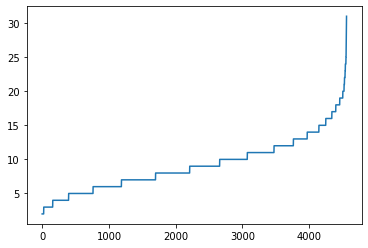

In [15]:
import numpy as np
import matplotlib.pyplot as plt

#the graph is plotted to analyse the number of words in the text
leng = list(len(li) for li in encoded_train_question_title)   
leng = np.sort(leng)
plt.plot([i for i in range(4559)],leng)
plt.show()

In [16]:
for i in range(90,100):
    print("{} pecentile : {}".format(i,leng[round(len(leng)*(i/100))]))

90 pecentile : 14
91 pecentile : 15
92 pecentile : 15
93 pecentile : 15
94 pecentile : 16
95 pecentile : 16
96 pecentile : 17
97 pecentile : 18
98 pecentile : 19
99 pecentile : 20


In [0]:
leng_question_title =20

In [0]:
train_question_title = pad_sequences(encoded_train_question_title, maxlen=leng_question_title, padding='post')
cv_question_title = pad_sequences(encoded_cv_question_title, maxlen=leng_question_title, padding='post')
test_question_title = pad_sequences(encoded_test_question_title, maxlen=leng_question_title, padding='post')

In [0]:
t = Tokenizer(filters = " ")
t.fit_on_texts(X_train['question_body'].values)
vocab_size_question_body = len(t.word_index) + 1
encoded_train_question_body = t.texts_to_sequences(X_train['question_body'].values)
encoded_cv_question_body = t.texts_to_sequences(X_cv['question_body'].values)
encoded_test_question_body = t.texts_to_sequences(test['question_body'].values)

In [0]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

# for train
embedding_matrix_model_question_body = np.zeros((vocab_size_question_body, 300))
for word, i in t.word_index.items():
    if word in glove_words:
        embedding_vector = model[word]
        embedding_matrix_model_question_body[i] = embedding_vector

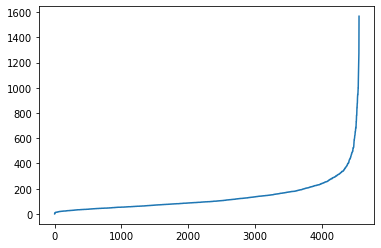

In [21]:
leng = list(len(li) for li in encoded_train_question_body)   
leng = np.sort(leng)
plt.plot([i for i in range(4559)],leng)
plt.show()

In [22]:
for i in range(90,100):
    print("{} pecentile : {}".format(i,leng[round(len(leng)*(i/100))]))

90 pecentile : 266
91 pecentile : 279
92 pecentile : 293
93 pecentile : 310
94 pecentile : 328
95 pecentile : 351
96 pecentile : 384
97 pecentile : 437
98 pecentile : 522
99 pecentile : 686


In [0]:
leng_question_body = 686

In [0]:
train_question_body = pad_sequences(encoded_train_question_body, maxlen=leng_question_body, padding='post')
cv_question_body = pad_sequences(encoded_cv_question_body, maxlen=leng_question_body, padding='post')
test_question_body = pad_sequences(encoded_test_question_body, maxlen=leng_question_body, padding='post')

In [0]:
t = Tokenizer(filters = " ")
t.fit_on_texts(X_train['answer'].values)
vocab_size_answer = len(t.word_index) + 1
encoded_train_answer = t.texts_to_sequences(X_train['answer'].values)
encoded_cv_answer = t.texts_to_sequences(X_cv['answer'].values)
encoded_test_answer = t.texts_to_sequences(test['answer'].values)

In [0]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

# for train
embedding_matrix_model_answer = np.zeros((vocab_size_answer, 300))
for word, i in t.word_index.items():
    if word in glove_words:
        embedding_vector = model[word]
        embedding_matrix_model_answer[i] = embedding_vector

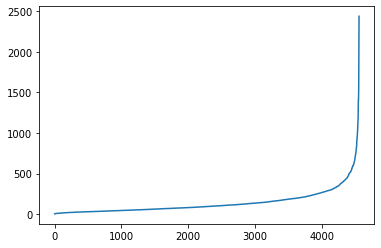

In [27]:
leng = list(len(li) for li in encoded_train_answer)   
leng = np.sort(leng)
plt.plot([i for i in range(4559)],leng)
plt.show()

In [28]:
for i in range(90,100):
    print("{} pecentile : {}".format(i,leng[round(len(leng)*(i/100))]))

90 pecentile : 292
91 pecentile : 302
92 pecentile : 323
93 pecentile : 344
94 pecentile : 376
95 pecentile : 410
96 pecentile : 444
97 pecentile : 513
98 pecentile : 601
99 pecentile : 771


In [0]:
leng_answer = 771

In [0]:
train_answer = pad_sequences(encoded_train_answer, maxlen=leng_answer, padding='post')
cv_answer = pad_sequences(encoded_cv_answer, maxlen=leng_answer, padding='post')
test_answer = pad_sequences(encoded_test_answer, maxlen=leng_answer, padding='post')

In [0]:
import tensorflow as tf
import keras
import os
import random as rn
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,concatenate,Input,Conv1D, MaxPooling1D, Dropout, Embedding,LSTM,BatchNormalization,Bidirectional
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback
np.random.seed(42)

tf.random.set_seed(32)

rn.seed(12)


In [41]:
K.clear_session()
input_1 = Input(shape=(leng_question_title,))
embed_1 = Embedding(vocab_size_question_title, 300, weights=[embedding_matrix_model_question_title],
                    input_length=leng_question_title,
                    embeddings_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23), 
                    trainable=False)(input_1)
lstm=Bidirectional(LSTM(32,activation='tanh',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26),
          return_sequences=True))(embed_1)
flat_1=Flatten()(lstm)

input_2 = Input(shape=(leng_question_body,))
embed_2 = Embedding(vocab_size_question_body, 300, weights=[embedding_matrix_model_question_body], 
                    input_length=leng_question_body, 
                    embeddings_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=24), 
                    trainable=False)(input_2)
lstm=Bidirectional(LSTM(32,activation='tanh',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=27),
          return_sequences=True))(embed_2)
flat_2=Flatten()(lstm)

input_3 = Input(shape=(leng_answer,))
embed_3 = Embedding(vocab_size_answer, 300, weights=[embedding_matrix_model_answer], 
                    input_length=leng_answer, 
                    embeddings_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=25), 
                    trainable=False)(input_3)
lstm=Bidirectional(LSTM(32,activation='tanh',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=28),
          return_sequences=True))(embed_3)
flat_3=Flatten()(lstm)

concat = concatenate([flat_1,flat_2,flat_3])

dense = Dense(32,activation = 'relu',kernel_initializer=tf.keras.initializers.he_normal(seed=40))(concat)

output = Dense(30,activation = 'sigmoid',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45))(dense)

model_lstm = Model(inputs = [input_1, input_2, input_3], outputs = output)

model_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 686)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 771)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 300)      2000700     input_1[0][0]                    
______________________________________________________________________________________________

In [0]:
class SpearmanCallback(Callback):
    def __init__(self, validation_data, patience, model_name):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.patience = patience
        self.value = -1
        self.bad_epochs = 0
        self.model_name = model_name

    def on_epoch_end(self, epoch, logs={}):
        y_pred_val = self.model.predict(self.x_val)
        rho_val = np.mean([spearmanr(self.y_val[:, ind], y_pred_val[:, ind]+ np.random.normal(0, 1e-7, y_pred_val.shape[0])).correlation for ind in range(y_pred_val.shape[1])])
        if rho_val >= self.value:
            self.value = rho_val
            self.bad_epochs = 0
            self.model.save_weights(self.model_name)
        else:
            self.bad_epochs += 1
        if self.bad_epochs >= self.patience:
            print("early stopping Threshold")
            self.model.stop_training = True
        print('\nbad: {}'.format(self.bad_epochs))
        print('\nval_spearman-corr: %s' % (str(round(rho_val, 4))), end=100*' '+'\n')
        return rho_val

In [0]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy') 

In [0]:
train_data = [train_question_title,train_question_body,train_answer]
cv_data = [cv_question_title,cv_question_body,cv_answer]

In [44]:
model_lstm.fit(train_data, y_train, batch_size=32, epochs=100, verbose=1, 
           validation_data=(cv_data, y_cv),
           callbacks=[SpearmanCallback(validation_data=(cv_data, y_cv),patience=5,
                       model_name='best_weights.h5')])

Epoch 1/100
143/143 [==============================] - ETA: 0s - loss: 0.4603
bad: 0

val_spearman-corr: 0.2019                                                                                                    
143/143 [==============================] - 28s 197ms/step - loss: 0.4603 - val_loss: 0.4056
Epoch 2/100
143/143 [==============================] - ETA: 0s - loss: 0.3966
bad: 0

val_spearman-corr: 0.2416                                                                                                    
143/143 [==============================] - 25s 172ms/step - loss: 0.3966 - val_loss: 0.3992
Epoch 3/100
143/143 [==============================] - ETA: 0s - loss: 0.3807
bad: 0

val_spearman-corr: 0.2516                                                                                                    
143/143 [==============================] - 23s 164ms/step - loss: 0.3807 - val_loss: 0.3963
Epoch 4/100
143/143 [==============================] - ETA: 0s - loss: 0.3678
bad: 0

va

In [45]:
%%time
model_lstm.load_weights("best_weights.h5")
y_pred_val = model_lstm.predict(cv_data)
sp = np.mean([spearmanr(y_cv[:, ind], y_pred_val[:, ind]).correlation for ind in range(y_pred_val.shape[1])])

CPU times: user 3.42 s, sys: 155 ms, total: 3.57 s
Wall time: 2.97 s


In [46]:
print("spearman {}".format(sp))

spearman 0.285042913938995
